# Predictive Marketing for CHANEL
Predict placement performance based on chanel history ad delivery

## Acquire OTV placement performance from CHANEL digital database

In [2]:
import pyodbc
import pandas as pd
import numpy as np
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER=10.2.186.233\\SQLINS02,5721;DATABASE=DM_1381_test;UID=Channel;PWD=Passw0rd')
sql = """
WITH CTE_SIZMEK_PLAC_PERF
AS
(
SELECT
	 [PlacementID]
	,SUM([Impressions]) AS Imp
	,MAX([LifetimePlacementUniqueImpressions]) AS UV
FROM [dbo].[DFID050844_GMMDUniqueReport_Extracted]
GROUP BY [PlacementID]
),
CTE_PLAC_PERF_SIZMEK
AS(
SELECT
	 A.[Product]
	,A.[Campaign]
	,A.[StartDate]
	,A.[StdMedia]
	,A.[Std.Format]
	,A.[Format]
	,A.[Drama]
	,A.[Target_Market]
	,A.[StdDevice]
	,A.Total_Est_Imp AS Est_Imp
	,A.Net_Media_Cost As Media_Cost
	,C.Imp AS Sizmek_Imp
	,C.UV AS Sizmek_UV
	,0 AS Nielsen_Imp
	,0 AS Nielsen_UV
	,0 AS Nielsen_TargetImp
FROM [dbo].[MediaPlan_CampaignPlacements_Chanel] A
INNER JOIN [dbo].[Y03_PlacementTrackingMap] B
ON A.[Symphony_Placement_Id]=B.[Symphony_Placement_Id]
INNER JOIN CTE_SIZMEK_PLAC_PERF C
ON B.[TrackingPlacementID]=C.[PlacementID]
WHERE Media_Type='OTV'
)
,
CTE_PLAC_PERF_NIELSEN
AS(
SELECT
	 A.[Product]
	,A.[Campaign]
	,A.[StartDate]
	,A.[StdMedia]
	,A.[Std.Format]
	,A.[Format]
	,A.[Drama]
	,A.[Target_Market]
	,A.[StdDevice]
	,0 AS Est_Imp
	,0 As Media_Cost
	,0 AS Sizmek_Imp
	,0 AS Sizmek_UV
	,E.[IMPR] AS Nielsen_Imp
	,E.[UNIQUE_AUDIENCE] AS Nielsen_UV
	,convert(bigint,E.[TRGT_PRCN] * E.[IMPR]) AS Nielsen_TargetImp
FROM [dbo].[MediaPlan_CampaignPlacements_Chanel] A
INNER JOIN [dbo].[Y03_PlacementNdarMap] D
ON A.[Symphony_Placement_Id]=D.[Symphony_Placement_Id]
INNER JOIN [dbo].[Y01_Nilsen_AudienceRating] E
ON D.[NilsenCmpgID]=E.[NilsenCmpgID] AND D.[NilsenPlcmID]=E.[NilsenPlcmID]
WHERE Media_Type='OTV'
)
,CTE_PLAC_PERF_RAW
AS(
SELECT * FROM CTE_PLAC_PERF_SIZMEK
UNION
SELECT * FROM CTE_PLAC_PERF_NIELSEN
)
SELECT
	 [Product]
	,[Campaign]
	,[StdMedia]
	,[Std.Format]
	,[Format]
	,[Drama]
	,[Target_Market]
	,[StdDevice]
	,[StartDate]
	,SUM(Est_Imp) AS Est_Imp
	,SUM(Media_Cost) AS Media_Cost
	,SUM(Sizmek_Imp) AS Sizmek_Imp
	,SUM(Sizmek_UV) AS Sizmek_UV
	,SUM(Nielsen_Imp) AS Nielsen_Imp
	,SUM(Nielsen_UV) AS Nielsen_UV
	,SUM(Nielsen_TargetImp) AS Nielsen_TargetImp
FROM CTE_PLAC_PERF_RAW
GROUP BY  [Product]
	,[Campaign]
	,[StdMedia]
	,[Std.Format]
	,[Format]
	,[Drama]
	,[Target_Market]
	,[StdDevice]
	,[StartDate]
"""
df_plac_perf = pd.read_sql(sql,cnxn)


## CLEAN DATA
- add col target_content which extract from Format
- generate new dataset group by Campaign, target_content, target_market, Std.Format, StdDevice
- remove bonus placements if media cost is 0
- show diff on imp/uv between sizmek/ nielsen. 
- use nielsen numbers to build model

In [80]:
df_plac_perf = df_plac_perf.assign(target_content = lambda x: x.Format.str.extract('[（|()](.+)') \
                                                       .str.split('，')
                                                       .str.get(1))
# fill na
df_plac_perf = df_plac_perf.fillna({'Drama':'N/A','Nielsen_Imp':0,'Nielsen_UV':0,'Nielsen_TargetImp':0})
df_plac_perf.loc[(df_plac_perf['Drama'].str.contains('《')),'target_content'] = 'drama buy'

# change type
df_plac_perf[['Sizmek_Imp','Sizmek_UV','Nielsen_Imp','Nielsen_UV','Nielsen_TargetImp']] =df_plac_perf[['Sizmek_Imp','Sizmek_UV','Nielsen_Imp','Nielsen_UV','Nielsen_TargetImp']].astype(np.int64)
df = df_plac_perf.groupby(['Product','Campaign','StdMedia','StdDevice','target_content','Target_Market','Drama'],as_index=False).aggregate(np.sum)
# remove bonus placements if media cost is 0
before_cnt = df.shape[0]
df = df.drop(df.index[df.Media_Cost<100])
after_cnt = df.shape[0]
print("remove bonus placements, before: %d, after: %d" %(before_cnt,after_cnt))
df = df.assign(imp_diff_pct = lambda x: (x.Sizmek_Imp-x.Nielsen_Imp)/x.Sizmek_Imp)
df = df.assign(uv_diff_pct = lambda x: (x.Sizmek_UV-x.Nielsen_UV)/x.Sizmek_Imp)
df = df[df.Sizmek_Imp>0]
df2 = df.loc[df.Nielsen_Imp>0].count()
# show diff
df.sort_values(['imp_diff_pct']).mean()

remove bonus placements, before: 4111, after: 4069


Est_Imp               1734638.635693
Media_Cost              81600.692171
Sizmek_Imp            2193501.253687
Sizmek_UV             1674383.428220
Nielsen_Imp           1411491.309489
Nielsen_UV             615110.849312
Nielsen_TargetImp    52195261.354966
imp_diff_pct                0.252765
uv_diff_pct                 0.402272
dtype: float64

## Mangling/ Normalize Data

In [105]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer()
for df['Product'].unique
#enc = preprocessing.OneHotEncoder().fit(df[['Product']].values)


AttributeError: 'function' object has no attribute 'value'

In [63]:
from sklearn import preprocessing
from sklearn import pipeline

scaler = preprocessing.StandardScaler()
pipe = pipeline.Pipeline([('scaler',scaler)])
std_arr = pipe.fit_transform(df[['Media_Cost','Sizmek_Imp','Sizmek_UV']])
#binarize Media Cost
binarizer = preprocessing.Binarizer()
binarizer.fit_transform(df[['Media_Cost']])


df_std = pd.DataFrame(std_arr,columns=('Media_Cost.std','Sizmek_Imp.std','Sizmek_UV.std'))
df = pd.concat([df,df_std],axis=1)
df=df.drop(df[df.Sizmek_Imp.isnull()].index)
#df['Sizmek_Imp.std']=np.log(df['Sizmek_Imp.std'])


## Diagonise dataset

TypeError: Empty 'DataFrame': no numeric data to plot

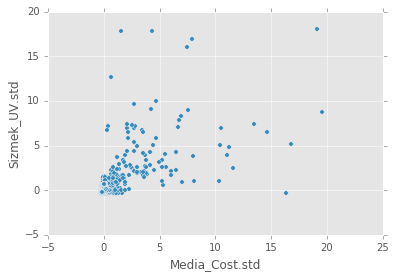

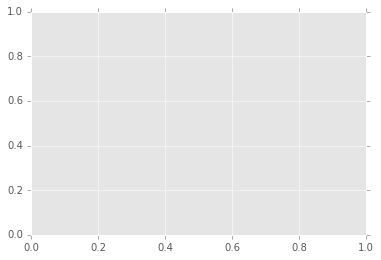

In [62]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

matplotlib.style.use('ggplot')

df.plot.scatter(x='Media_Cost.std',y='Sizmek_UV.std')
plt.figure()
pd.cut(df['Media_Cost'],bins=[0,100000,1000000]).plot.bar(by='Media_Cost')

In [ ]:
df_plac_perf[['Media_cost','UV']].plot

## Build Model

In [ ]:
import statsmodels.formula.api as smf